In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#%matplotlib notebook

# Problem 1

Complete the function `poisson_square` by implementing the finite difference method given in the lab. Use `scipy.sparse.linalg.spsolve` to solve the linear system. Use your function to solve the boundary value problem:

\begin{align}
	\begin{split}
	\Delta u = 0, &{}\quad x \in [0,1]\times [0,1],\\
	u(x,y) = x^3, &{}\quad (x,y) \in \partial ([0,1]\times [0,1]).
	\end{split}
	\label{poisson2d:laplace}
\end{align}

Use $n=100$ subintervals for both $x$ and $y$. Plot the solution as a 3D surface.

In [3]:
def poisson_square(a,b,c,d,f,g,n):
    """Computes the finite difference method for the Poisson equation boundary-value
    problem on a square:
        
        u_xx + u_yy = f on R = [a,b]×[c,d]
        u = g on ∂R
    
    where (b-a) = (d-c).
        
    Parameters:
        a (float): left-hand boundary for x
        b (float): right-hand boundary for x
        c (float): lower boundary for y
        d (float): uppder boundary for y
        f (function): right-hand side of the PDE
        g (function): boundary condition
        n (int): number of subintervals
    Returns:
        U (ndarray of shape (n+1,n+1)): approximate solution
    """
    # initialize values along with T and A matrices ####################
    h = (b - a)/n
    x_vals = np.linspace(a, b, n + 1)
    y_vals = np.linspace(c, d, n + 1)
    T = sp.diags([[1]*(n - 2), [-4]*(n - 1), [1]*(n - 2) ], np.array([-1, 0, 1]))
    A = sp.bmat([[T if i == j else sp.identity(n-1) if abs(i-j)==1
                else None for i in range(n-1)]
                for j in range(n-1)], format='csr')
    A = A*(1/(h**2))
    
    # construct p, q, and f ############################################
    p = []
    q = [g(x_vals[i + 1], y_vals[0]) for i in range(n - 1)]
    for j in range(1, n):
        p += [g(x_vals[0], y_vals[j])]
        p += [0]*(n - 3)
        p += [g(x_vals[n], y_vals[j])]
        q += [0]*(n - 3)
        
    q += [g(x_vals[i+1], y_vals[n]) for i in range(n-1)]
    p = np.array(p) / (h**2)
    q = np.array(q) / (h**2)
    f_vals = []
    for j in range(1, n):
        f_vals += [f(x_vals[i], y_vals[j]) for i in range(1, n)]
    f_vals = np.array(f_vals)
    
    # find solution ####################################################
    rhs = f_vals - p - q
    result = (sp.linalg.spsolve(A, rhs)).reshape((n - 1, n - 1))
    X, Y = np.meshgrid(x_vals, y_vals)
    sol = g(X, Y)
    sol[1:-1, 1:-1] = result 
    
    return sol

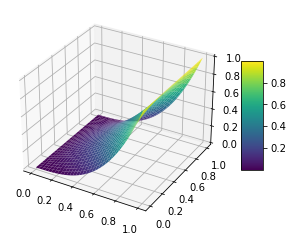

In [4]:
# initialize values ####################################################
f = lambda x, y: 0
g = lambda x, y: x**3
n = 100
sol = poisson_square(0, 1, 0, 1, f, g, n)
x = np.linspace(0, 1, n + 1)
y = np.linspace(0, 1, n + 1)
X, Y = np.meshgrid(x, y)

# plot results #########################################################
fig = plt.figure()
ax = plt.axes(projection = '3d')
surface = ax.plot_surface(X, Y, sol, cmap="viridis", linewidth=0)
fig.colorbar(surface, shrink = 0.5, aspect=5)
plt.show()

# Problem 2

Solve 

\begin{align}
	\begin{split}
	\Delta V = -\rho(x,y), &{}\quad x \in [-2,2]\times [-2,2],\\
	u(x,y) = 0, &{}\quad (x,y) \in \partial ([-2,2]\times [-2,2]).
	\end{split}
	\label{poisson2d:source}
\end{align}

for the electric potential $V.$ Use the source function defined above, such that $\rho(x,y) = \text{source}(x,y)$. Use $n=100$ subintervals for $x$ and $y$. Use the provided code to plot your solution.

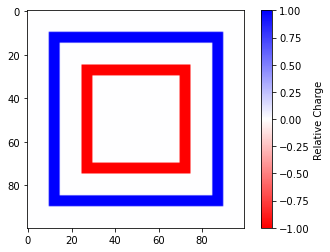

In [5]:
import matplotlib.colors as mcolors

def source(X,Y):
    """
    Takes arbitrary arrays of coordinates X and Y and returns an array of the same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-1.5) < .1,abs(X+1.5) < .1) ,abs(Y) <  1.6),
    np.logical_and( np.logical_or(abs(Y-1.5) < .1,abs(Y+1.5) < .1) ,abs(X) <  1.6))] = 1
    
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-0.9) < .1,abs(X+0.9) < .1) ,abs(Y) <  1.0),
    np.logical_and( np.logical_or(abs(Y-0.9) < .1,abs(Y+0.9) < .1) ,abs(X) <  1.0))] = -1
    return src
    
#Generate a color dictionary for use with LinearSegmentedColormap
#that places red and blue at the min and max values of data
#and white when data is zero
def genDict(data):
    zero = 1/(1 - np.max(data)/np.min(data))
    cdict = {
    'red': [(0.0, 1.0, 1.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'green': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'blue': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 1.0, 1.0)]
    }
    return cdict

a1 = -2.
b1 = 2.
c1 = -2.
d1 = 2.
n =100
X = np.linspace(a1,b1,n)
Y = np.linspace(c1,d1,n)
X,Y = np.meshgrid(X,Y)

plt.imshow(source(X,Y), cmap = mcolors.LinearSegmentedColormap('cmap', genDict(source(X,Y))))
plt.colorbar(label="Relative Charge")
plt.show()

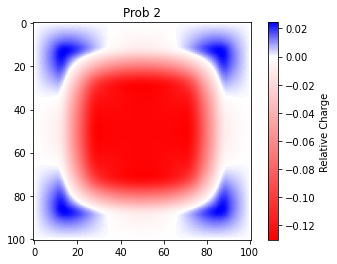

In [6]:
# initialize values ####################################################
f = lambda x, y: -1*source(x, y)
g = lambda x, y: x*0
n = 100
sol = poisson_square(-2, 2, -2, 2, f, g, n)

# plot results #########################################################
plt.figure()
plt.imshow(sol, cmap = mcolors.LinearSegmentedColormap('cmap', genDict(sol)))
plt.title("Prob 2")
plt.colorbar(label="Relative Charge")
plt.show()